In [1]:
import wandb
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback
)
import warnings

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

from datasets import load_dataset, concatenate_datasets, Dataset
import logging
from collections import Counter

from sklearn.model_selection import train_test_split
import pandas as pd
import time
import matplotlib.pyplot as plt
import sys, os
import torch
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import time
from gliner import GLiNER



c:\Users\Timia\anaconda3\envs\algtrading\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
ds = load_dataset("ChanceFocus/flare-fiqasa")
df = pd.read_csv("financial_phrasebank.csv")
labels = {0:"negative", 1:"neutral", 2:"positive"}


In [132]:
fpb = df.drop(columns=["english_sentence"])
fpb = fpb.rename(columns={"norwegian_sentence" : "text"})
fpb["label"] = fpb["label"].map(labels)

In [131]:
merged_flare:Dataset = concatenate_datasets([d for d in ds.values()])
flare = merged_flare.to_pandas()
flare.drop(columns=["id", "query", "choices", "gold"], inplace=True)
flare.rename(columns={"answer":"label"}, inplace=True)

In [ ]:
frames = [flare,fpb]
merged = pd.concat(frames, ignore_index=True)

In [139]:
# Split into train (70%), temp (30%) then split temp into validation/test (50% each)
train, temp = train_test_split(df, test_size=0.3, random_state=42)
val, test = train_test_split(temp, test_size=0.5, random_state=42)

train.to_csv("train.csv", index=False)
val.to_csv("validation.csv", index=False)
test.to_csv("test.csv", index=False)


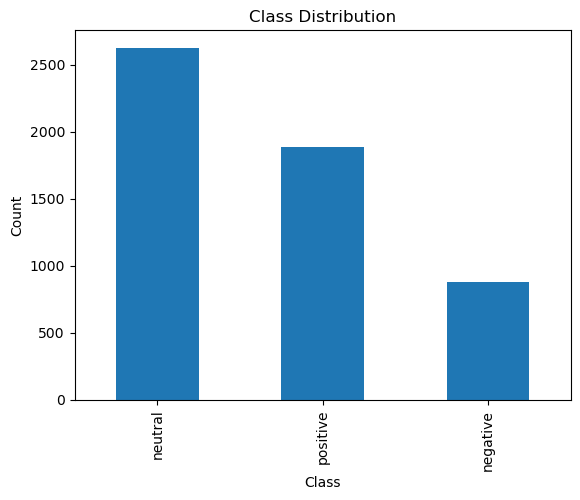

In [138]:
merged["label"].value_counts().plot(kind="bar")
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()
plt.close()

In [15]:
text = """DNB ASA is the largest financial services group in Norway. It offers services in over 19 countries, including Denmark, Sweden, and the UK."""
text = "De siste årene har norske eiere solgt hundrevis av barnehagebygg til utenlandske investorer for milliardbeløp. Disse barnehagene betaler nesten dobbelt så høy husleie som andre private barnehager, viser en analyse gjennomført av Utdanningsnytt og E24. Én av dem er Norlandia Glassverket barnehage i Bærum.Nå har Utdanningsdirektoratet hatt tilsyn med barnehagen. De mener husleien ligger langt over markedspris, noe som er brudd på barnehageloven. Direktoratet har hyret inn analyseselskapet Veridian Analyse til å gjøre en uavhengig vurdering av husleienivået. Vurderingen tilsier at leieprisen har vært dobbelt så høy som den burde vært, ifølge direktoratet. – Med forbehold om at Veridian har vurdert alminnelig leie korrekt, så er avviket helt uvanlig høyt, sier Sølve Bærug, førsteamanuensis ved Institutt for eiendom og juss ved NMBU."
text = "Offshore-gründer til Erna Solberg: – Jeg skulle gjerne hatt økt skatt på selskaper som leverer gode resultater. Høyre ønsker både å fjerne skatt på «arbeidende kapital» og lette skattetrykket for unge i etableringsfasen. Det er enda noen uker til valgkampen for alvor er i gang, men flere partier har begynt å varme opp med smått hektisk reisevirksomhet land og strand i en tidlig jakt etter velgere."
text = "Reuters: Zelenskyj i samtaler med Norge og flere andre land om felles våpenproduksjon. Ukrainas president Volodymyr Zelenskyj sier de skal inngå avtale med Norge, Danmark, Tyskland, Canada, Storbritannia og Litauen om felles våpenproduksjon. Ukraina planlegger å signere avtalen i sommer om å starte å eksportere våpenproduksjonsteknologi. Avtalene er allerede på plass, ifølge den ukrainske presidenten."
text = "DNB har rettet feil i nettbanken. DNB hadde lørdag morgen problemer med sin nettbank. Klokken 9.50 meldte banken at feilen var rettet. Til VG opplyste DNB at andre tjenester fungerte som normalt, og at kunder kommer inn på banken via mobilbank. Det er ikke kjent hva feilen skyldtes."
text = "Rec Silicon trenger penger. Selskaper melder fredag kveld i en børsmelding at de ikke har kapital tilgjengelig til å møte gjeldsforpliktelser eller operasjonskostnader for inneværende år. De er derfor avhengige av sin største aksjonær, Hanwha, skriver de i meldingen. De skriver videre at de snart må sikre seg kapital, men vet ennå ikke når eller hvordan de skal løse dette. I samme melding opplyser Rec Silicon at de har gjennomført en intern gjennomgang med et eksternt advokatfirma av de faktiske forholdene som ble tatt opp i en ekstraordinær generalforsamling og granskning 16. mai. Selskapet fant ingen forseelser."
text = "Veidekke sikrer milliardkontrakt. veidekke har inngått en totalentreprise verdt 2,3 milliarder kroner for bygging av Utsikten for Kongsberg Defence & Aerospace. Grunnarbeidene er allerede i gang, og bygget har planlagt ferdigstillelse i første halvår 2028. Oppdraget går inn i Veidekkes ordreserve for andre kvartal 2025, ifølge en børsmelding. Det nye bygget i Kongsberg Teknologipark blir på totalt 65.000 kvadratmeter fordelt over åtte etasjer og vil romme rundt 2.300 arbeidsplasser. – Dette er et stort og viktig prosjekt for svært mange lokalt, nasjonalt og internasjonalt, og det er viktig for oss i Veidekke, sier konsernsjef Jimmy Bengtsson i Veidekke."

labels = ["organization", "location", "company", "industry"]

def benchmark(model_name):
    model = GLiNER.from_pretrained(model_name)
    start = time.time()
    entities = model.predict_entities(text, labels)
    print(f"{'Entity':<25} {'Type':<15} {'Confidence':<10}")
    print('-' * 50)
    for ent in entities:
        print(f"{ent['text']:<25} {ent['label']:<15} {ent['score']:.2f}")
    duration = time.time() - start
    print(f"{model_name} took {duration:.2f}s")
    #print("Entities:", entities)

models = [
    "urchade/gliner_small-v2.1",
    "urchade/gliner_medium-v2.1",
    "urchade/gliner_large-v2.1"
]

for m in models:
    benchmark(m)


Fetching 4 files: 100%|██████████| 4/4 [00:00<?, ?it/s]
c:\Users\Timia\anaconda3\envs\algtrading\Lib\site-packages\transformers\convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Entity                    Type            Confidence
--------------------------------------------------
Veidekke                  company         0.90
veidekke                  company         0.86
Kongsberg Teknologipark   location        0.87
Veidekke                  company         0.84
Veidekke                  company         0.82
urchade/gliner_small-v2.1 took 0.33s


Fetching 5 files: 100%|██████████| 5/5 [00:00<?, ?it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Entity                    Type            Confidence
--------------------------------------------------
Veidekke                  company         0.73
veidekke                  company         0.74
Kongsberg Teknologipark   location        0.84
Veidekke                  company         0.71
Veidekke                  company         0.73
urchade/gliner_medium-v2.1 took 0.62s


Fetching 4 files: 100%|██████████| 4/4 [00:00<?, ?it/s]
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Entity                    Type            Confidence
--------------------------------------------------
Veidekke                  location        0.99
veidekke                  location        0.98
Kongsberg Defence & Aerospace company         0.93
Veidekke                  location        0.99
Veidekke                  location        0.99
urchade/gliner_large-v2.1 took 1.54s
